In [91]:
import torch
from models.gspnp.lightning_GSDRUNet import StudentGrad

In [92]:
device='cuda'

In [93]:
model=StudentGrad(network='unet',numInChan=3,numOutChan=3).to('cuda')

In [94]:
model.model.load_state_dict(torch.load('miscs/unet.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

In [95]:
from PIL.Image import open as imopen
import numpy as np

In [96]:
X=torch.tensor(np.asarray(imopen('/export1/project/zihao/data/CBSD68/test/105025.png')),dtype=torch.float32,device='cpu')[:256,:256,:]

In [97]:
X=X.permute(2,0,1).unsqueeze(0)

In [98]:
X.shape

torch.Size([1, 3, 256, 256])

In [99]:
import matplotlib.pyplot as plt

In [100]:
X=(X/255.).to(device)

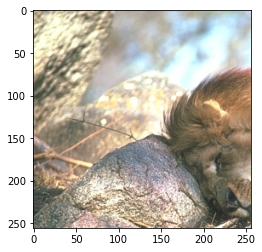

In [101]:
plt.imshow(X[0,:,:,:].detach().permute(1,2,0).cpu().numpy())

In [102]:
Xblur=X+torch.FloatTensor(X.size()).normal_(mean=0, std=7.65/255.).to(X.device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


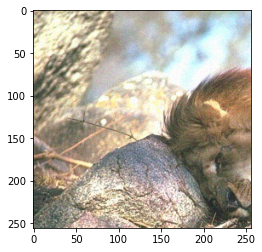

In [103]:
plt.imshow(Xblur[0,:,:,:].detach().permute(1,2,0).cpu().numpy())

In [104]:
from skimage.metrics import peak_signal_noise_ratio as psnr

In [105]:
psnr(X[0,:,:,:].detach().permute(1,2,0).cpu().numpy(),Xblur[0,:,:,:].detach().permute(1,2,0).cpu().numpy())

30.435302110841622

In [106]:
Xdenoise=Xblur-model.grad(Xblur,7.65/255.,False)

In [107]:
psnr(X[0,:,:,:].detach().permute(1,2,0).cpu().numpy(),Xdenoise[0,:,:,:].detach().permute(1,2,0).cpu().numpy())

37.07380121079034

In [108]:
from models.pnp import PNP
from models.deqFixedPoint import DEQFixedPoint,nesterov,simpleIter

In [109]:
model=PNP(10.0,0.1,model,'deblurring').to(device)

In [110]:
from hdf5storage import loadmat

In [111]:
kernels=loadmat('miscs/Levin09.mat')['kernels']
kernel=kernels[0,1]

In [112]:
from torch.nn.functional import conv2d,pad

In [113]:
kernelTensor=torch.tensor(kernel,dtype=torch.float32,device=X.device)
kernelTensor=kernelTensor.unsqueeze(0).unsqueeze(0)
kernelTensor=kernelTensor.expand(X.shape[1],1,kernelTensor.shape[2],kernelTensor.shape[3]).to(device)
degradImg=conv2d(pad(X,(kernelTensor.shape[3]//2,kernelTensor.shape[3]//2,kernelTensor.shape[2]//2,kernelTensor.shape[2]//2),mode='circular'),kernelTensor,groups=3)
noise=torch.FloatTensor(degradImg.size()).normal_(mean=0, std=7.65/255.).to(degradImg.device)
Xblur=degradImg+noise

In [114]:
Xblur=torch.tensor(np.asarray(imopen('img_9_blur.png')),dtype=torch.float32,device=device).permute(2,0,1).unsqueeze(0)/255.
im2=torch.tensor(np.asarray(imopen('img_8_blur.png')),dtype=torch.float32,device=device).permute(2,0,1).unsqueeze(0)/255.
Xblur=torch.cat([Xblur,im2],dim=0)

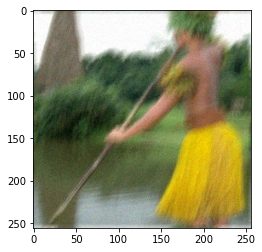

In [115]:
plt.imshow(Xblur[0,:,:,:].detach().permute(1,2,0).cpu().numpy())

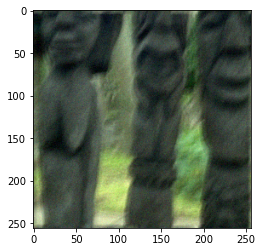

In [116]:
plt.imshow(Xblur[1,:,:,:].detach().permute(1,2,0).cpu().numpy())

In [117]:
model.initialize_prox(Xblur,kernel)

In [118]:
X0=model.calculate_prox(Xblur)

In [120]:
Xrecon=nesterov(lambda z:model(z,13.770,False),X0,50)
Xrecon=model(Xrecon.requires_grad_(), 13.770)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


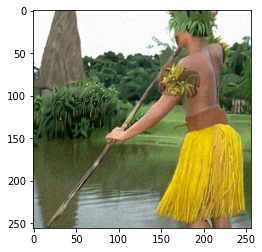

In [89]:
plt.imshow(Xrecon[0,:,:,:].detach().permute(1,2,0).cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


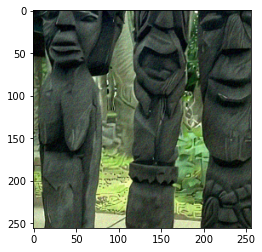

In [90]:
plt.imshow(Xrecon[1,:,:,:].detach().permute(1,2,0).cpu().numpy())

In [77]:
import utils.utils_sr as utils_sr

In [78]:

def calculate_F(x,s,img,lamb):
        '''
        Calculation of the objective function value f + lamb*s
        :param x: Point where to evaluate F
        :param s: Precomputed regularization function value
        :param img: Degraded image
        :return: F(x)
        '''

        deg_x = utils_sr.imfilter(x,model.k_tensor[0].flip(1).flip(2).expand(3,-1,-1,-1))
        F = 0.5 * torch.norm(img - deg_x, p=2) ** 2 + lamb * s
        return F.item()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


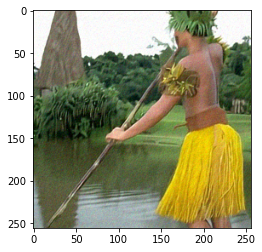

In [79]:
relative_diff_F_min=1e-6
diff_F=1
F_old=1
maxitr=30
i=0
lamb=0.1
tau=10.0
x=X0
model.initialize_prox(Xblur,kernel)
while i < maxitr and abs(diff_F)/F_old > relative_diff_F_min:
    i+=1
    sigma_denoiser = 13.770

    x_old = x

    #Denoising of x_old and calculation of F_old
    Ds, f = model.rObj.grad2(x_old, sigma_denoiser / 255.)
    Ds = Ds.detach()
    f = f.detach()
    Dx = x_old -   Ds
    s_old = 0.5 * (torch.norm(x_old.double() - f.double(), p=2) ** 2)
    F_old = calculate_F(x_old, s_old, Xblur,lamb)

    backtracking_check = False

    while not backtracking_check:

        # Gradient step
        z = (1 - lamb * tau) * x_old + lamb * tau * Dx

        # Proximal step
        x = model.calculate_prox(z)

        # Calculation of Fnew
        f = model.rObj.grad2(x, sigma_denoiser / 255.)[1]
        f = f.detach()
        s = 0.5 * (torch.norm(x.double() - f.double(), p=2) ** 2)
        F_new = calculate_F(x,s,Xblur,lamb)

        # Backtracking
        diff_x = (torch.norm(x - x_old, p=2) ** 2).item()
        diff_F = F_old - F_new
        if diff_F < (0.1 / tau) * diff_x and abs(diff_F)/F_old > relative_diff_F_min:
            backtracking_check = False
            tau = 0.9 * tau
            x = x_old
        else:
            backtracking_check = True
plt.imshow(x[0,:,:,:].detach().permute(1,2,0).cpu().numpy())
plt.show()

        

        